In [3]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [4]:
# Define transformations for the training and testing data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Download and load the training data
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

# Download and load the testing data
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

# Class labels for CIFAR-10
classes = ['plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [02:03<00:00, 1.38MB/s] 


In [5]:
# Define the Neural Network
class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        
        self.model = nn.Sequential(
            nn.Flatten(),                # Flatten the input from 3D (C, H, W) to 1D (C*H*W)
            nn.Linear(3 * 32 * 32, 512),  # Input layer: 3x32x32 → 512 neurons
            nn.ReLU(),                   # Activation
            nn.Linear(512, 256),          # Hidden layer: 512 → 256 neurons
            nn.ReLU(),
            nn.Linear(256, 10)            # Output layer: 256 → 10 classes
        )

    def forward(self, x):
        return self.model(x)

# Instantiate the model and move it to the device (CPU or GPU)
model = CIFAR10Classifier().to(device)
print(model)

CIFAR10Classifier(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [6]:
# Loss function: Cross-Entropy Loss (good for classification tasks)
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam (a popular optimizer that works well in practice)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Define number of epochs
num_epochs = 10

# To record loss and accuracy
train_losses = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    ##################
    # Training Phase
    ##################
    model.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    ##################
    # Validation Phase
    ##################
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradients needed during evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)

    ##################
    # Print Epoch Summary
    ##################
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Accuracy: {test_accuracies[-1]:.2f}%')

Epoch [1/10], Train Loss: 1.6376, Test Loss: 1.5167, Accuracy: 46.17%
Epoch [2/10], Train Loss: 1.4273, Test Loss: 1.4254, Accuracy: 49.54%
Epoch [3/10], Train Loss: 1.3194, Test Loss: 1.3649, Accuracy: 52.48%
Epoch [4/10], Train Loss: 1.2271, Test Loss: 1.3485, Accuracy: 52.30%
Epoch [5/10], Train Loss: 1.1464, Test Loss: 1.3773, Accuracy: 52.47%
Epoch [6/10], Train Loss: 1.0742, Test Loss: 1.3867, Accuracy: 53.21%
Epoch [7/10], Train Loss: 0.9982, Test Loss: 1.4002, Accuracy: 52.46%
Epoch [8/10], Train Loss: 0.9260, Test Loss: 1.4581, Accuracy: 52.78%
Epoch [9/10], Train Loss: 0.8561, Test Loss: 1.4640, Accuracy: 53.20%
Epoch [10/10], Train Loss: 0.7972, Test Loss: 1.5807, Accuracy: 52.49%


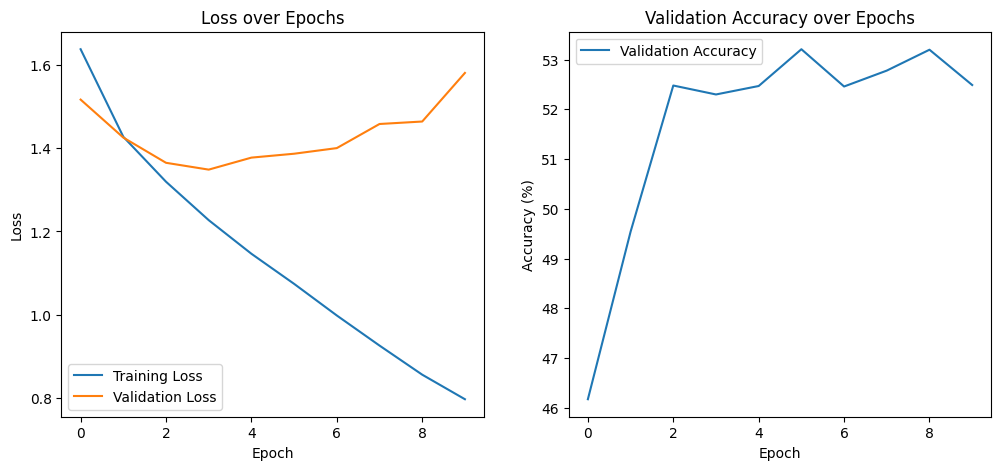

In [8]:
# Plot Training Loss and Test Loss
plt.figure(figsize=(12,5))

# Plot losses
plt.subplot(1,2,1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1,2,2)
plt.plot(test_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [9]:
# Save the trained model to a file
model_path = './cifar10_classifier.pth'
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to ./cifar10_classifier.pth
